In [ ]:
!{sys.executable} -m conda install astropy

In [1]:
from utils import Candidate
from utils import Quadrant
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
#from astropy.visualization import ZScaleItnterval
from astropy.visualization import ZScaleInterval
import astropy.wcs as wcs
#from crowdsource import crowdsource_base

import psf
import crowdsource_base

from crowdsource_functions import utils

help(utils.get_full_pos)

Help on function get_full_pos in module crowdsource_functions:

get_full_pos(pars, s, c)



### Goal:
1. Do Dr. Knop's crowdsource on the reference image. Make sure the model and subtraction are much better.
2. Generate a reference csv file.
3. Based on the reference csv file, do Dr. Knop's crowdsource on another random image. Make sure the model and subtraction are much better.
4. Experiment with using gaussian vs. moffat psfs and toggling the refit_sky and other parameters on and off.

In [2]:
# def get_weight(weighthdul, c):
#     return np.flipud(weighthdul[1].data[c[2]:c[3], c[0]:c[1]]) # Gets flipped because of numpy indexing

# def get_full_pos(pars, s):
#     ypres = np.reshape(pars[0]["y"], (pars[0]["x"].shape[0], 1))
#     xpres = np.reshape(pars[0]["x"], (pars[0]["x"].shape[0], 1))

#     xs = xpres[xpres>0][ypres[xpres>0]>0]
#     ys = ypres[xpres>0][ypres[xpres>0]>0]

#     xs = np.reshape(xs, (xs.shape[0], 1))
#     ys = np.reshape(ys, (xs.shape[0], 1))

#     ypre = xs - s
#     xpre = ys - s

#     y = -1*ypre
#     x = xpre

#     ypre = y + s - 1
#     xpre = x + s

#     xref = xpre + ymin
#     yref = ypre + xmin
    
#     return xref, yref

# def get_radecs(imhdul, xref, yref):
#     ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
#     return ws.wcs_pix2world(np.transpose(np.array([xref, yref+0.5]))[0], 0)  
#     # return the Ra/Dec positions as a numpy array (ofset by 0.5 pixels to account for differences in numpy indexed image and full image xlim/ylim)
    

# def get_rel_pos(xref, yref, s):
#     # Get Relative Positions
#     xref = x - ymin
#     yref = y - xmin

#     xref = xref - s
#     yref = yref - s

#     yref = -1*yref

#     xref = xref + s
#     yref = yref + s

#     yref = yref-1
    
#     return xref, yref

# def get_xys(imhdul, radecs):   
#     ws = wcs.WCS(imhdul[1].header)  # create a wcs object with the quadrant object's header
#     xys = ws.wcs_world2pix(radecs, 0)  # return the Ra/Dec positions as a numpy array

#     x = np.transpose(xys)[0]
#     y = np.transpose(xys)[1]
    
#     return x, y

In [3]:
# Get the reference and test images

name = "DC21saaw"
radec = (270.31184, -28.77637)
c = Candidate(name, radec)
c.start()
iid = c.get_image_ids()
imref_fp, wref_fp = c.get_fp("c4d_210322_091756_ori") # Tuple of image and weight file
imfnames, wfnames = zip(*c.get_all_fps()) # List of tuples of image and weight files
c.close()

In [4]:
# STEP 1: Define picture radius and Ra Decs. Load Images
s = 32
radec = (270.31177, -28.776405) # Updated ra/dec manually
radec = (270.31178, -28.77640)
imhdul = fits.open(imref_fp) # get a file
weighthdul = fits.open(wref_fp)

# Create a quadrant and get image tile
q = Quadrant(imhdul, (2*s, 2*s)) # start a tile
subim, c = q.get_tile((radec[0], radec[1])) # Get the image centered on the int near radect
ymin, ymax, xmin, xmax = c

# weight = np.flipud(weighthdul[1].data[c[2]:c[3], c[0]:c[1]])
weight = utils.get_weight(weighthdul, c)

psf_ = psf.gaussian_psf(4, deriv=False) # get the psf stamps
psf_ = np.reshape(psf_, (19, 19)) # reshape the psf into the shape the SimplePSF object needs.
psf__ = psf.SimplePSF(psf_) # make a SimplePSF psf object with the stamps.

#psf__ = psf.MoffatPSF(4, beta=3)
    
#CROWDSOURCE GET XS AND YS
pars = crowdsource_base.fit_im(subim, psf__, weight=weight, 
                           verbose=True, miniter=4, maxiter=10, 
                           refit_psf=True, derivcentroids=True, refit_sky = False) # Get the crowdsource fit (including sky subtraction).



# Get Full Postions

xref, yref = utils.get_full_pos(pars, s, c)
radecs = utils.get_radecs(imhdul, xref, yref)

Extension None, iteration  1, found     35 sources;    0 close and    0 faint sources removed.
Extension None, iteration  2, found     16 sources;    0 close and    0 faint sources removed.
Fewer than 5 stars accepted in image, keeping original PSF
Extension None, iteration  3, found      2 sources;    0 close and    0 faint sources removed.
Fewer than 5 stars accepted in image, keeping original PSF
Extension None, iteration  4, found      0 sources;    0 close and    0 faint sources removed.


starting reference image


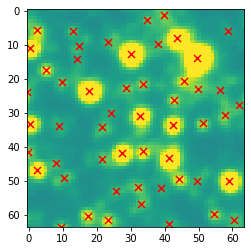

reference model image


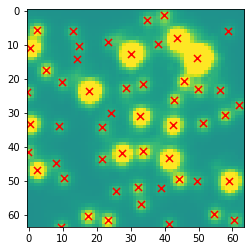

reference difference image


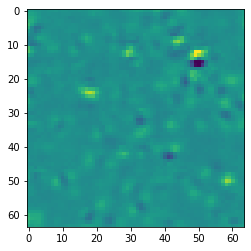

In [5]:
print("starting reference image")
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference model image")
plt.imshow(pars[1], vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference difference image")
plt.imshow(subim - pars[1], vmin=-1600, vmax=1600 )
plt.show()

In [8]:
imhdul = fits.open(imref_fp) # get another file
weighthdul = fits.open(wref_fp)

imhdul = fits.open(imfnames[2]) # get a file
weighthdul = fits.open(wfnames[2])


q = Quadrant(imhdul, (2*s, 2*s)) # start a tile
subim, c = q.get_tile((radec[0], radec[1])) # Get the image centered on the int near radect
ymin, ymax, xmin, xmax = c
weight = np.flipud(weighthdul[1].data[c[2]:c[3], c[0]:c[1]])


x, y = utils.get_xys(imhdul, radecs)

xref, yref = utils.get_rel_pos(x, y, s, c)

# Run Crowdsource Forced Fit

psf_ = psf.gaussian_psf(4, deriv=False) # get the psf stamps
psf_ = np.reshape(psf_, (19, 19)) # reshape the psf into the shape the SimplePSF object needs.
psf__ = psf.SimplePSF(psf_) # make a SimplePSF psf object with the stamps.

psf__ = psf.MoffatPSF(4, beta=3)
    
#CROWDSOURCE GET XS AND YS
pars_ = crowdsource_base.fit_im_force(subim, 
                                 yref, xref, 
                                 psf__, weight = weight, psfderiv = False, derivcentroids=False, refit_psf=True, refit_sky = True, startsky = 0) # Do the forced fit

Iteration 1, median sky   0.00
Iteration 2, median sky  28.86
Iteration 3, median sky  40.84
Iteration 4, median sky  57.97


starting reference image


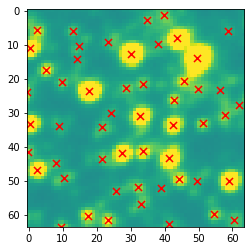

reference model image


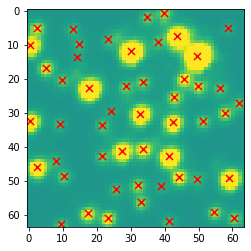

reference difference image


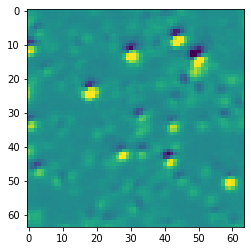

In [9]:
print("starting reference image")
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference model image")
plt.imshow(pars_[1], vmin=-1600, vmax=1600 )
plt.scatter(pars_[0]["y"], pars_[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference difference image")
plt.imshow(subim - pars_[1], vmin=-1600, vmax=1600 )
plt.show()